## Overview

This notebook provides an exploration of audio data from animals, performing analysis through statistical analysis and visualisation of audio samples

Author: akudilcz

## Pre-requisites to run this notebook.

This notebook explores a data set that is stored on the Deakin teams channel here:

[DataSets Folder](https://deakin365.sharepoint.com/:f:/r/sites/DataBytes2/Shared%20Documents/Project%20Echo/DataSets?csf=1&web=1&e=oxQZWj)

This dataset was not uploaded to git to keep the repository light weight.  This notebook assumes the dataset has been mapped to your local drive - see paths below

## Development environment

This notebook requires a conda environment setup in accordance with [Data Science Environment Setup](https://github.com/stephankokkas/Project-Echo/tree/main/src)

In [1]:
# disable warnings to tidy up output
import warnings
warnings.filterwarnings("ignore")

# some basic libraries 
from platform import python_version
#import pandas as pd
#import seaborn as sns
import numpy as np
import os
import random

# plot support
import matplotlib.pyplot as plt

# tensorflow support
import tensorflow as tf
import tensorflow_transform as tft
import tensorflow_io as tfio

# scipy
import scipy

# reading audio datasets
import librosa
import librosa.display

# turn off tensorflow warnings
tf.get_logger().setLevel('ERROR')

# turn off absl warnings
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

# print system information
print('Python Version     : ', python_version())
print('TensorFlow Version : ', tf.__version__)
print('Librosa Version    : ', librosa.__version__)

Python Version     :  3.9.13
TensorFlow Version :  2.10.0
Librosa Version    :  0.9.2


In [2]:
# below code adapted from:
# https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(123)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
random.seed(123)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(1234)

In [3]:
# set system parameters
DATASET_PATH  = 'C:/Users/Andrew/OneDrive - Deakin University/DataSets/birdclef2022/'
SAMPLE_RATE   = 32000
MIN_FREQUENCY = 16
MAX_FREQUENCY = 4096*3
HOP_LENGTH    = 128
NUMBER_FFT    = 2048
NUMBER_MELS   = 128
CLIP_LENGTH   = 10   # only look at 10 seconds of clip at the start of loaded audio file

# prefer dark background for plots
plt.style.use('dark_background')

In [4]:
def dataset_from_dir_structure(dataset_path):
    # each subdir represents a data class
    subfolders = [f for f in os.scandir(dataset_path) if f.is_dir()]

    dataset_filenames = []
    dataset_labels = []
    
    # dictionary of datasets grouped into classes
    target_datasets = {}
    
    for subfolder in subfolders:
        # now get all the files in the folder
        audiofiles = [f for f in os.scandir(subfolder.path) if f.is_file()]
        
        target_filenames = []
        target_labels = []
        
        for audiofile in audiofiles:
            dataset_filenames.append(audiofile.path)
            dataset_labels.append(subfolder.name)
            target_filenames.append(audiofile.path)
            target_labels.append(subfolder.name)
    
        # per-target datasets
        target_dataset = tf.data.Dataset.from_tensor_slices((target_filenames, target_labels))
        target_datasets[subfolder.name] = target_dataset     
            
    # create the dataset from tensor slices
    dataset = tf.data.Dataset.from_tensor_slices((dataset_filenames, dataset_labels))
    
    return dataset, target_datasets

In [5]:
# create the dataset
file_dataset,target_datasets = dataset_from_dir_structure(DATASET_PATH)
print("Dataset Samples: ", len(file_dataset))
print("Dataset Labels : ", target_datasets.keys())

# print three elements of the file_dataset pipeline
for file, label in file_dataset.take(3):
    print ("FILE: ",file.numpy().decode("utf-8"), " LABEL: ", label.numpy().decode("utf-8"))

Dataset Samples:  524
Dataset Labels :  dict_keys(['brant', 'jabwar', 'sheowl', 'spodov', 'wiltur'])
FILE:  C:/Users/Andrew/OneDrive - Deakin University/DataSets/birdclef2022/brant\XC112697.ogg  LABEL:  brant
FILE:  C:/Users/Andrew/OneDrive - Deakin University/DataSets/birdclef2022/brant\XC127691.ogg  LABEL:  brant
FILE:  C:/Users/Andrew/OneDrive - Deakin University/DataSets/birdclef2022/brant\XC143518.ogg  LABEL:  brant


In [6]:
# this function converts filename to actual audio 2d array data
def load_audio_file(audio_file, label):
    
    # load audio as an IOTensor
    audio = tfio.audio.AudioIOTensor(audio_file, dtype=tf.float32)
    
    # convert to tensor and keep only 10 seconds worth of the left channel
    audio_t = audio.to_tensor()[0:audio.rate*CLIP_LENGTH,0]
    
    return audio_t, audio.rate, label

# scale the audio amplitude to range(-1,1)
def scale_audio(audio,rate, label):
    audio = audio - tf.reduce_min(audio)
    audio = 2.0*(audio / (tf.reduce_max(audio)+tf.keras.backend.epsilon()))-1.0
    return audio,rate,label

# standardise the sample rate through re-sampling
def standardise_sample_rate(audio, rate, label):
    audio = tfio.audio.resample(audio, rate_in=tf.cast(rate, tf.int64), rate_out=SAMPLE_RATE)
    return audio,tf.Variable(SAMPLE_RATE),label

# make a data pipeline
def make_data_pipeline(dataset):
    # now to create a pipeline to load the audio file
    audio_dataset = (dataset
                    .map(load_audio_file)
                    .map(standardise_sample_rate)
                    .map(scale_audio)
                    .cache()
                    .repeat()
                    )
    return audio_dataset
    
audio_dataset = make_data_pipeline(file_dataset)

# check the data loaded ok
for audio, rate, label in audio_dataset.take(3):
    audio_np = audio.numpy()
    print (audio_np.shape, rate.numpy(), np.min(audio_np), np.max(audio_np), label.numpy().decode("utf-8"))

(320000,) 32000 -1.0 0.99999976 brant
(320000,) 32000 -1.0 0.99999976 brant
(320000,) 32000 -1.0 0.99999964 brant


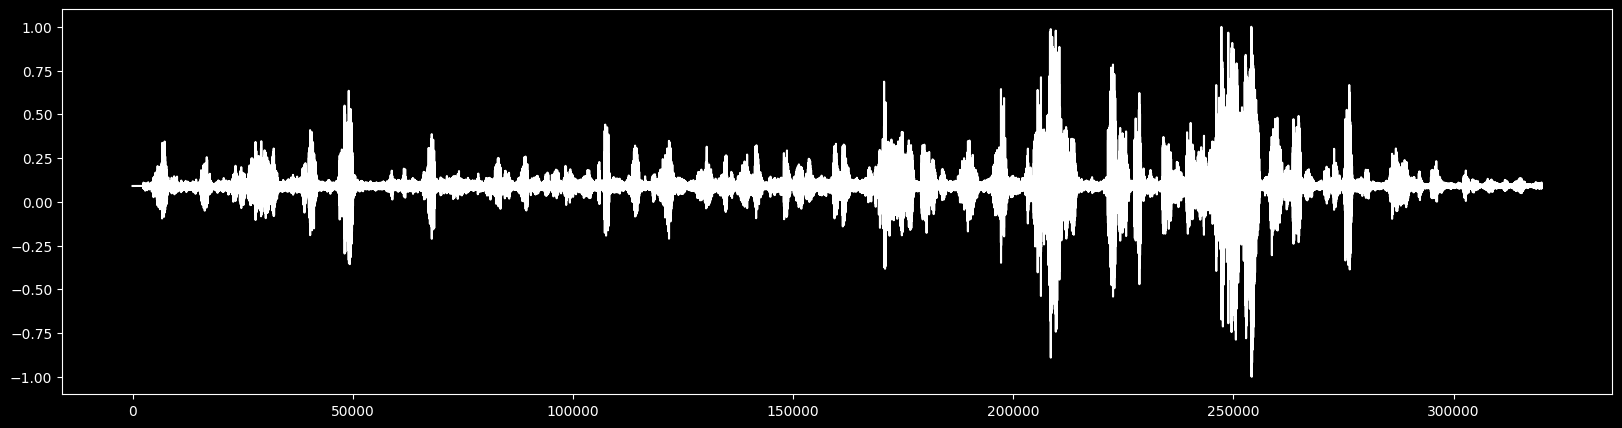

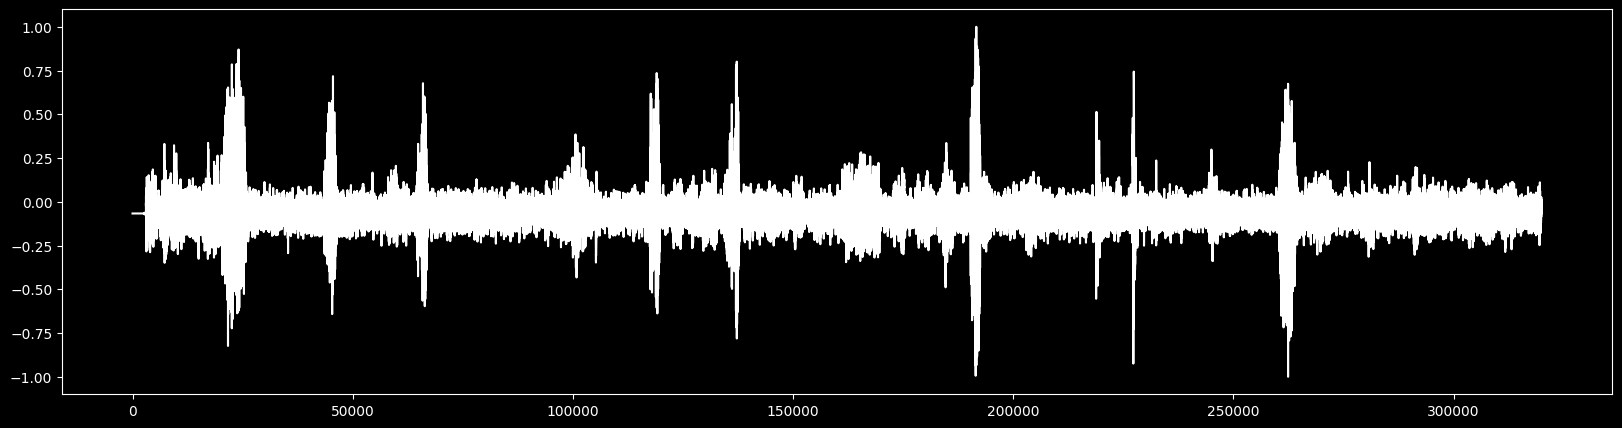

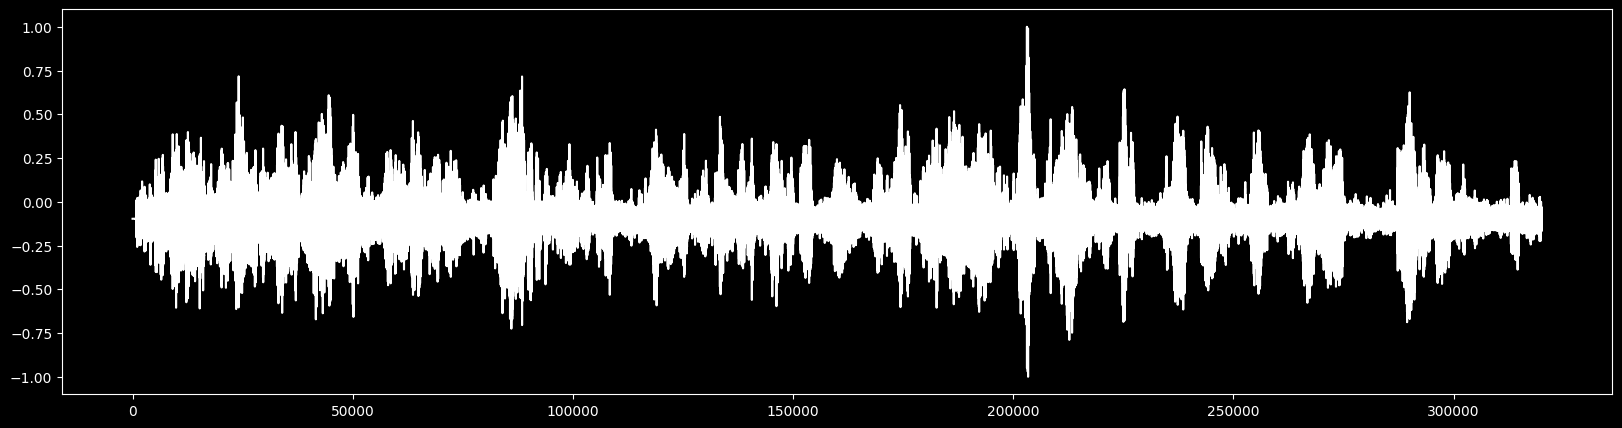

In [7]:
# plot three samples of audio
for audio, rate, label in audio_dataset.take(3):
    audio_np = audio.numpy()
    plt.figure(figsize=(20,5))
    plt.plot(audio_np, color="white")

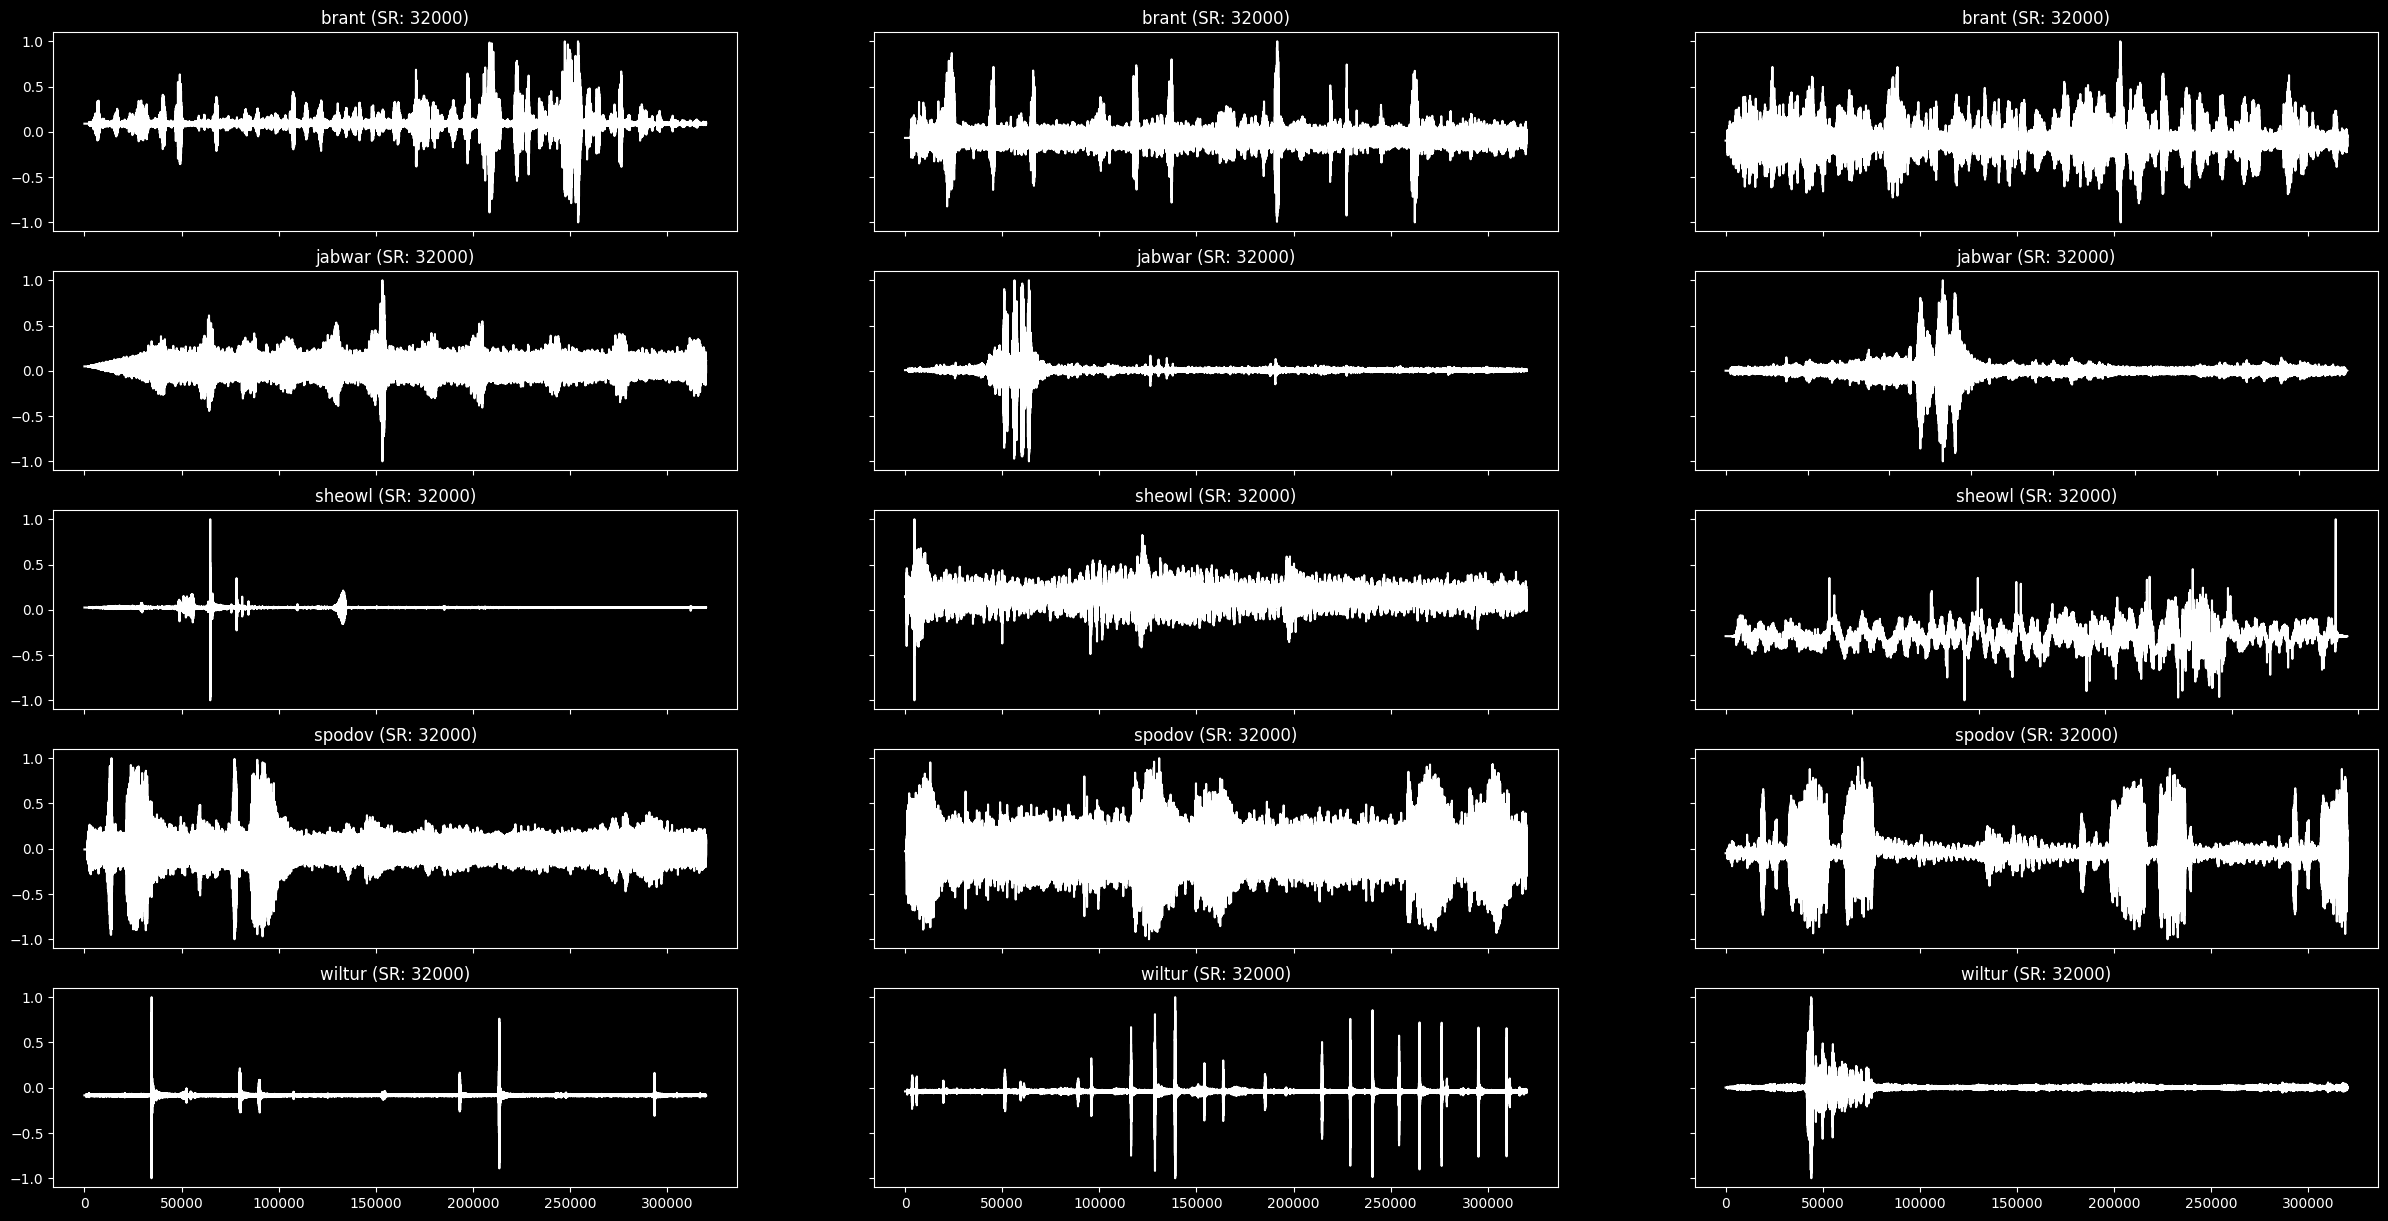

In [8]:
# plot three samples of audio from each target class
fig, axs = plt.subplots(nrows=len(target_datasets), ncols=3, figsize=(30,15))

for target_index, target in enumerate(target_datasets.keys()):
    
    # now to create a pipeline to load the audio file
    audio_dataset = make_data_pipeline(target_datasets[target])
      
    for audio_index, (audio, rate, label) in enumerate(audio_dataset.take(3)):
        audio_np = audio.numpy()
        axs[target_index, audio_index].plot(audio_np, color="white")
        axs[target_index, audio_index].set_title(label.numpy().decode("utf-8")+  " (SR: "+ str(rate.numpy())+")")
        
for ax in axs.flat:
    ax.label_outer()

In [9]:
def make_feature_plots(f_feature, title):
    # plot three samples of audio from each target class
    N_COLS=3

    fig, axs = plt.subplots(nrows=len(target_datasets), ncols=N_COLS, figsize=(30,10), sharex=True)
    plt.title(title)
    
    for target_index, target in enumerate(target_datasets.keys()):
        
        # now to create a pipeline to load the audio file
        audio_dataset = make_data_pipeline(target_datasets[target])  
        
        for audio_index, (audio, rate, label) in enumerate(audio_dataset.take(N_COLS)):
            
            # convert to numpy array
            audio_np = audio.numpy()[0:rate*CLIP_LENGTH] 
            
            # apply the feature function
            audio_feature = f_feature(audio_np, rate.numpy()) 
                                
            # show the spectrum
            librosa.display.specshow(audio_feature, 
                                    x_axis='time', 
                                    # y_axis='log', 
                                    sr=rate.numpy(), 
                                    hop_length=HOP_LENGTH,
                                    fmin=MIN_FREQUENCY, 
                                    fmax=MAX_FREQUENCY,
                                    ax=axs[target_index, audio_index])
            axs[target_index, audio_index].set_title(label.numpy().decode("utf-8"))
        
    for ax in axs.flat:
        ax.label_outer()

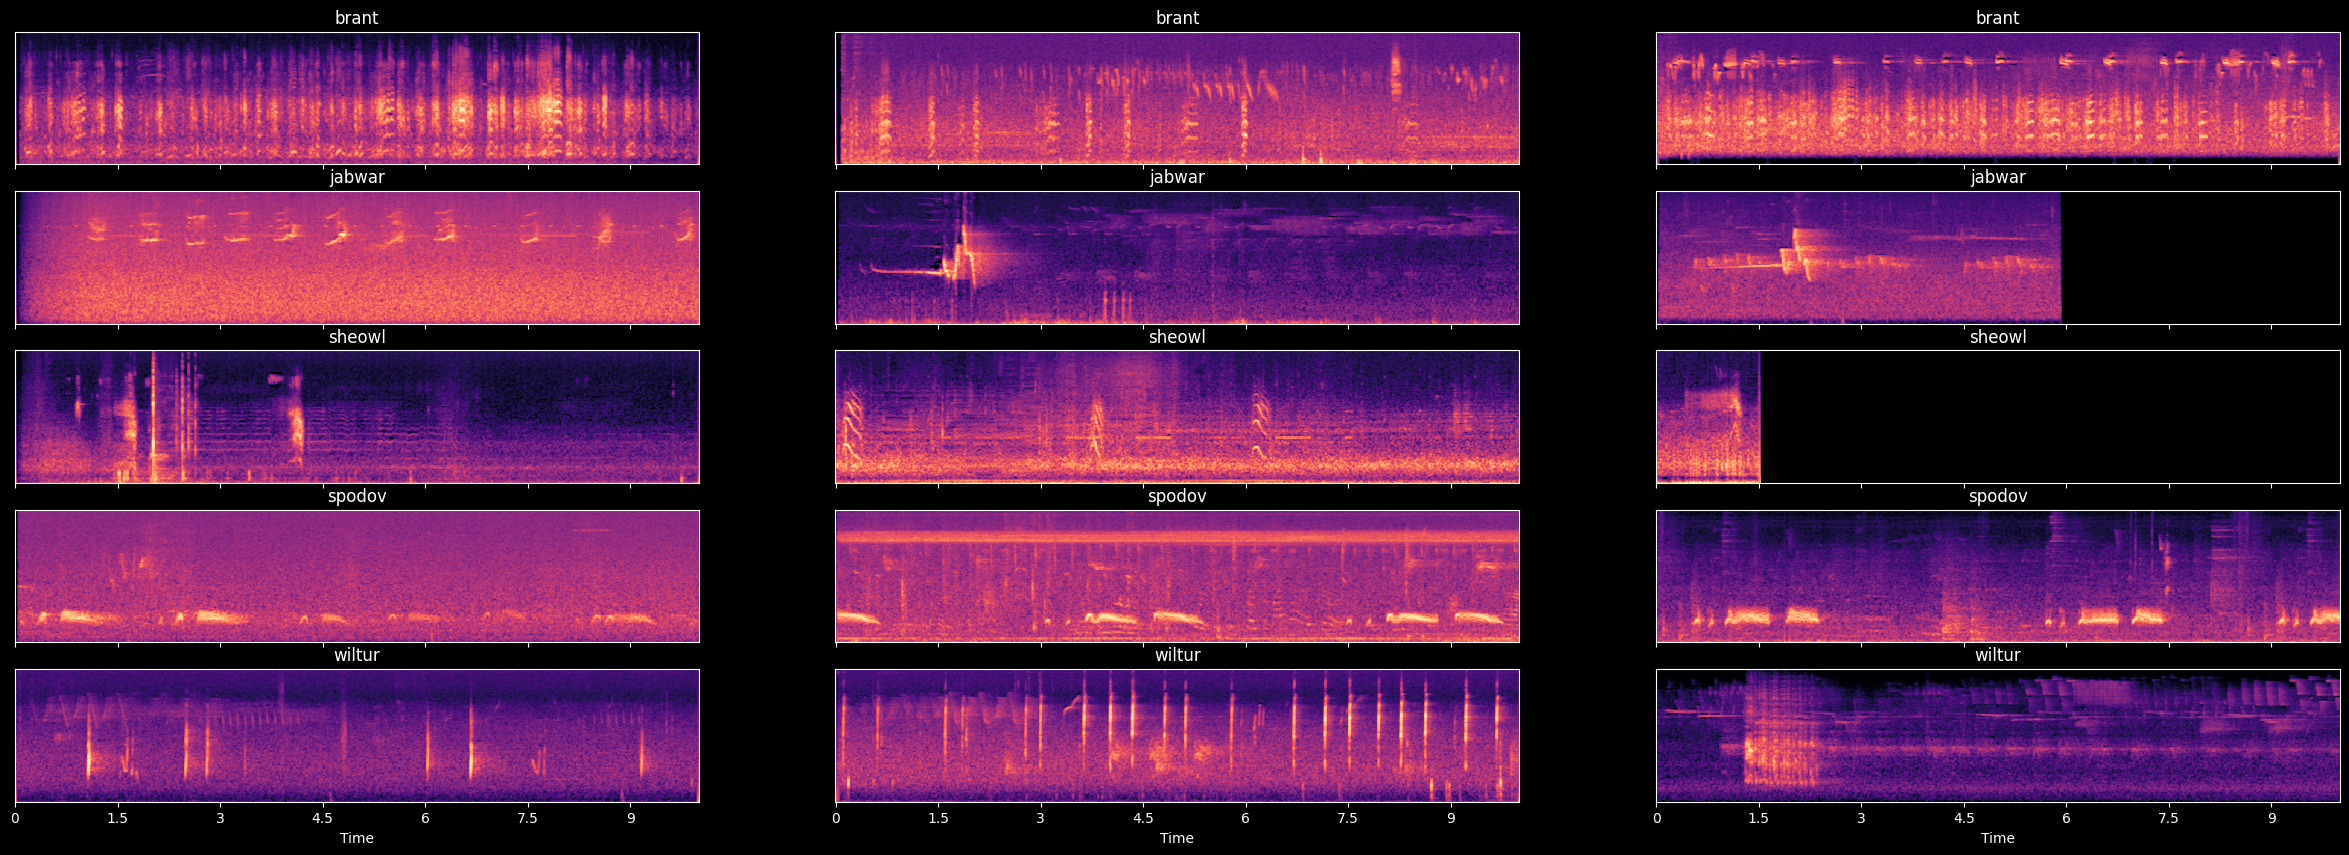

In [10]:
 # generate melspectrogram visualisation
def feature_melspectrogram(audio,rate):
    melspec = librosa.feature.melspectrogram(audio, 
                                            sr=rate, 
                                            S=None, 
                                            n_fft=NUMBER_FFT, 
                                            hop_length=HOP_LENGTH, 
                                            win_length=None, 
                                            window='hann', 
                                            center=True, 
                                            n_mels=NUMBER_MELS,
                                            pad_mode='constant',
                                            fmin=MIN_FREQUENCY,
                                            fmax=MAX_FREQUENCY,
                                            power=2.0)
    
    # convert to db
    melspec_db = librosa.power_to_db(melspec, ref=np.max)
    
    return melspec_db
        
make_feature_plots(lambda audio,rate: feature_melspectrogram(audio,rate), "melspectrogram")

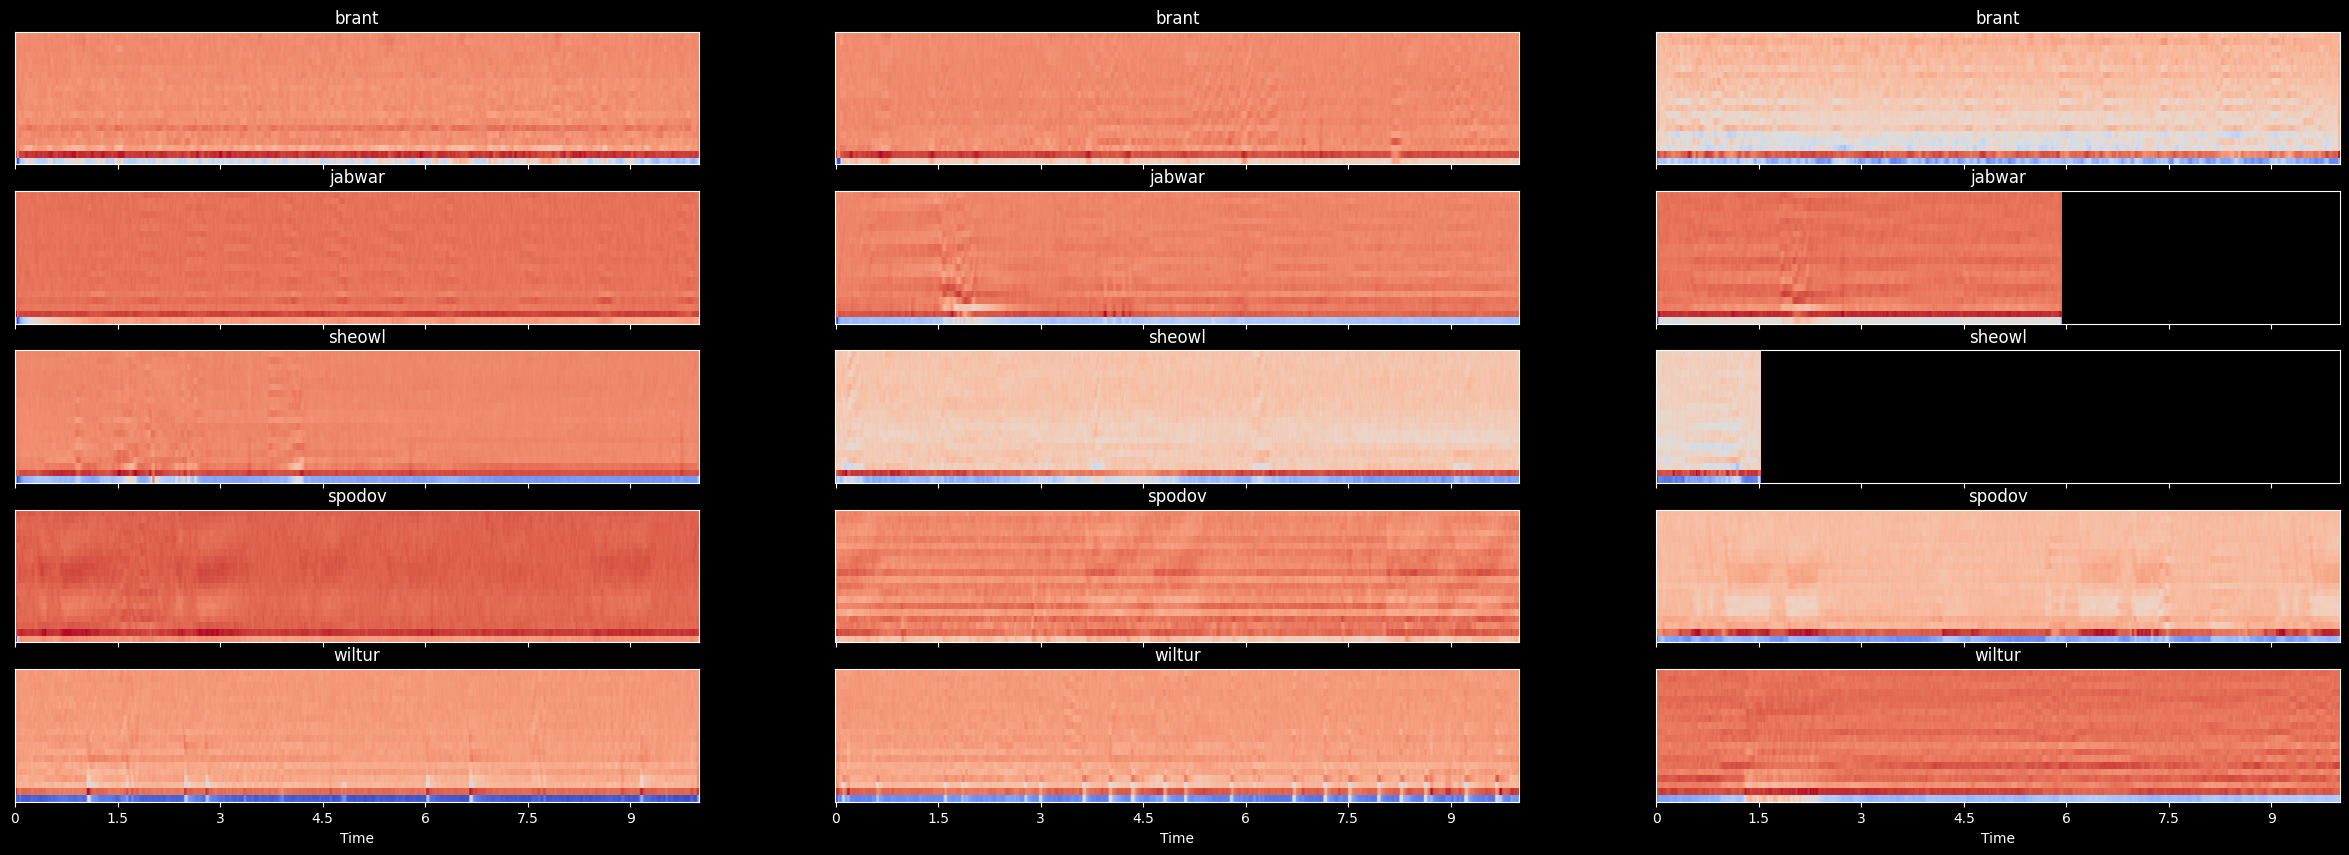

In [11]:
 # generate mfcc visualisation
def feature_mfcc(audio,rate):
    mfcc = librosa.feature.mfcc(audio, 
                                sr=rate, 
                                S=None, 
                                n_fft=NUMBER_FFT, 
                                hop_length=HOP_LENGTH, 
                                win_length=None, 
                                window='hann', 
                                center=True, 
                                n_mels=NUMBER_MELS,
                                pad_mode='constant',
                                fmin=MIN_FREQUENCY,
                                fmax=MAX_FREQUENCY,
                                power=2.0)
    return mfcc
        
make_feature_plots(lambda audio,rate: feature_mfcc(audio,rate), "mfcc")

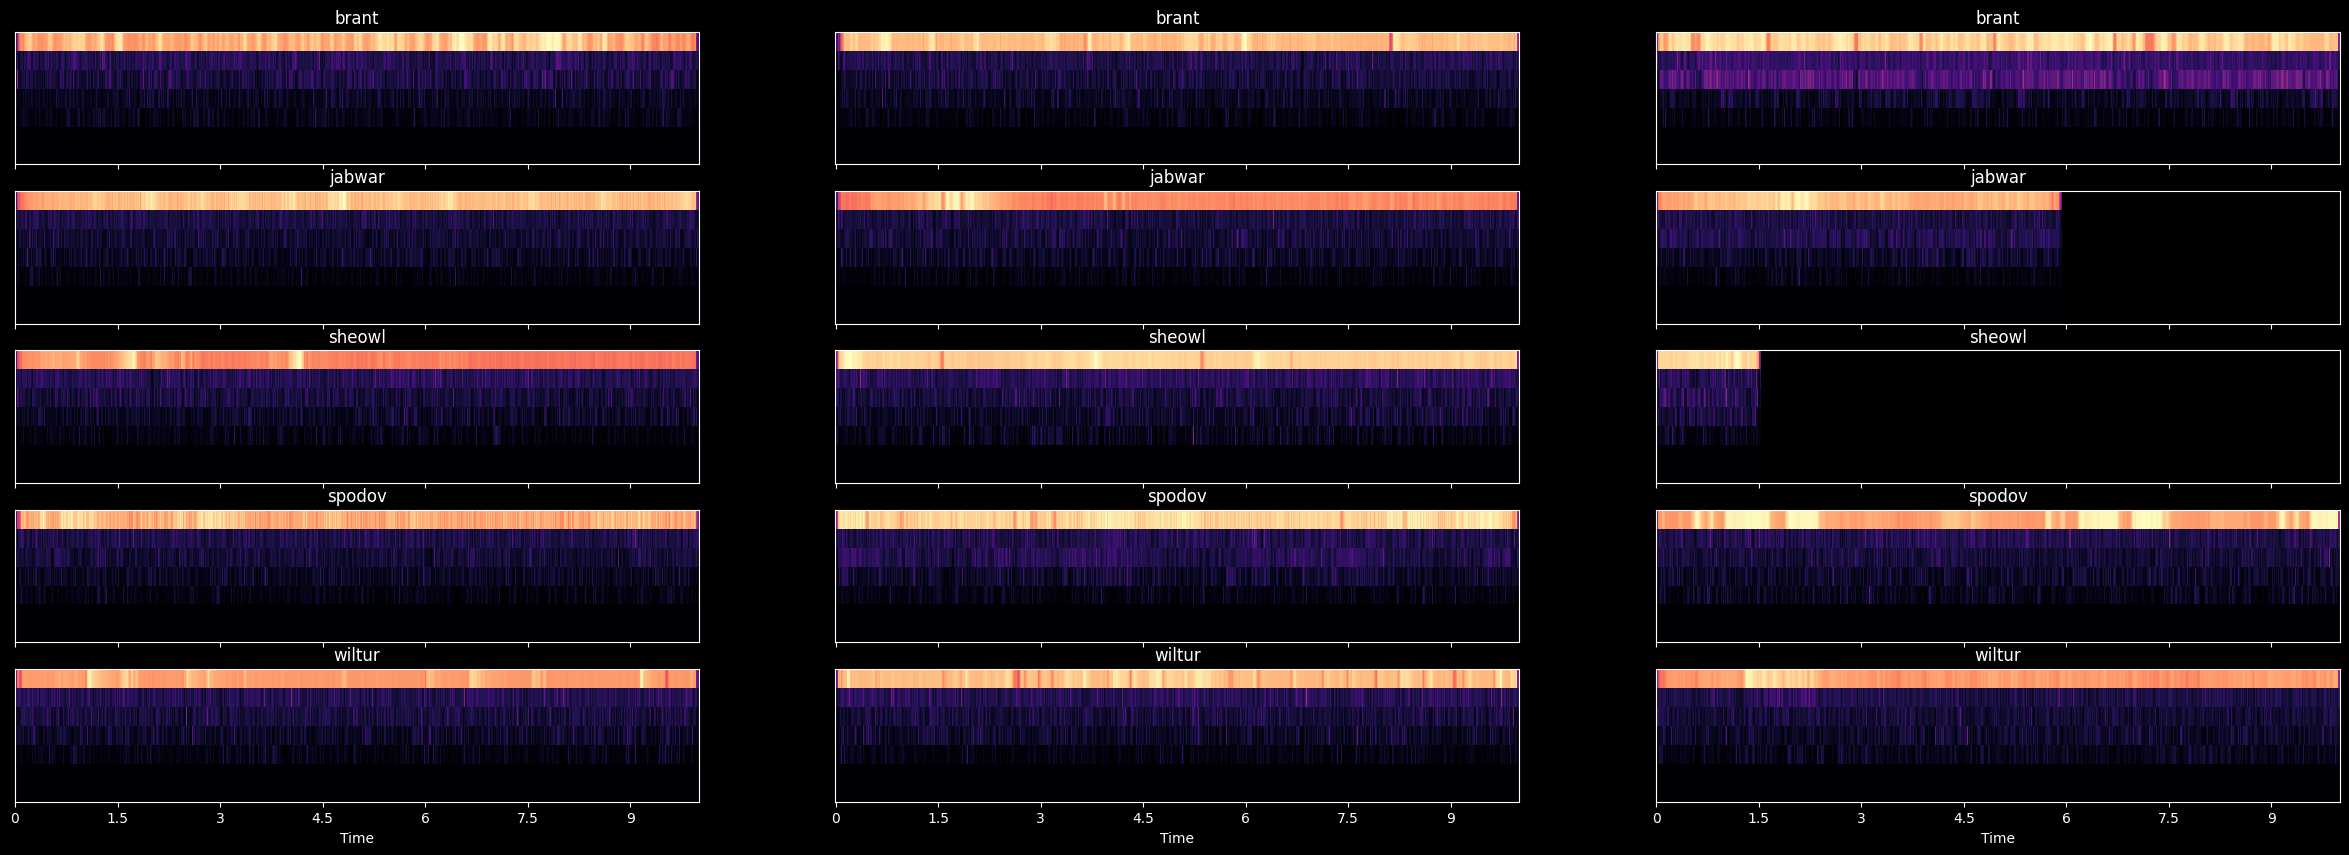

In [12]:
 # generate spectral_contrast visualisation
def feature_spectral_contrast(audio,rate):
    feature = librosa.feature.spectral_contrast(audio, 
                                sr=rate, 
                                S=None, 
                                n_fft=NUMBER_FFT, 
                                hop_length=HOP_LENGTH, 
                                win_length=None, 
                                window='hann', 
                                center=True, 
                                pad_mode='constant',
                                fmin=MIN_FREQUENCY,
                                )
    return feature
        
make_feature_plots(lambda audio,rate: feature_spectral_contrast(audio,rate), "spectral_contrast")

#### Using Descrete Cosign Transform with FFT
The scipy.fft.dct() method can compute the discrete cosine transform by selecting different types of sequences and return the transformed array by using this method - an effective way to convert the images to arrays.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.fft.dct.html

In literatue review, this technique helped derive the short-term energy, zero-crosssing rate, and bandwidth by extracting the Cepstral Coefficients.

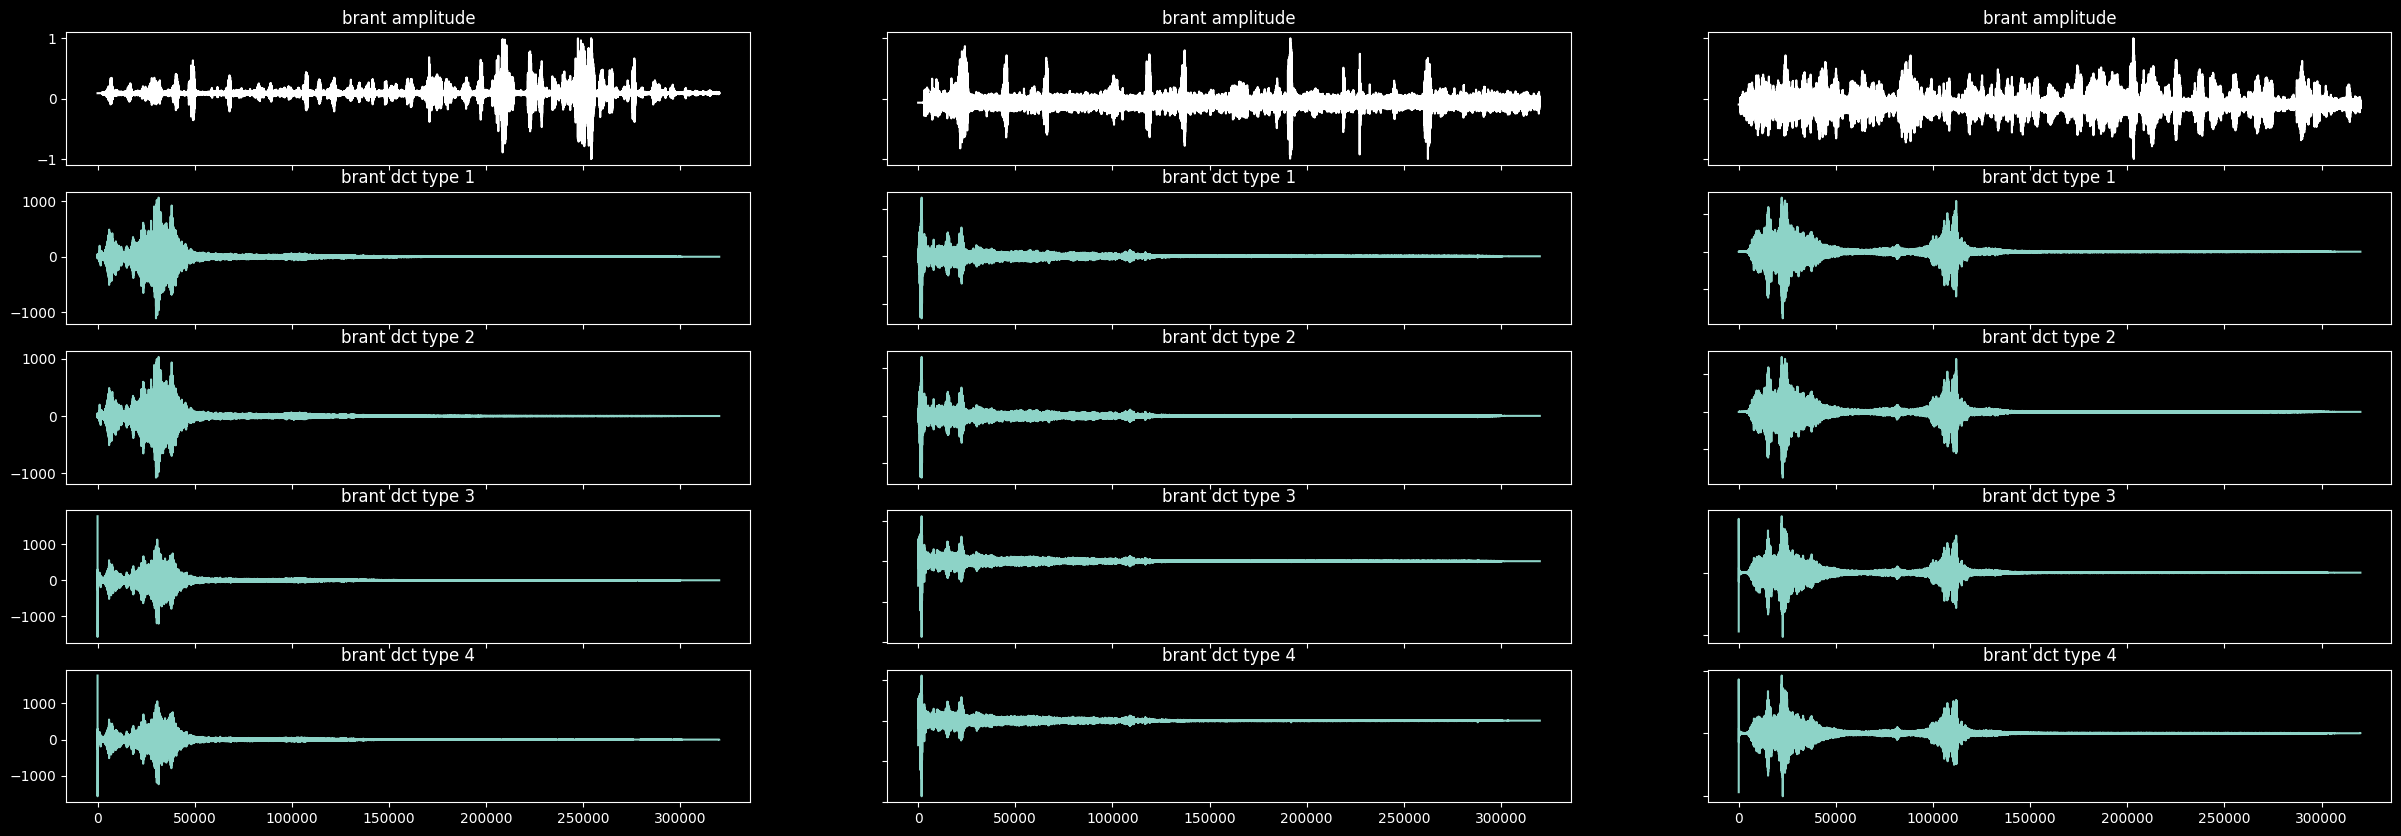

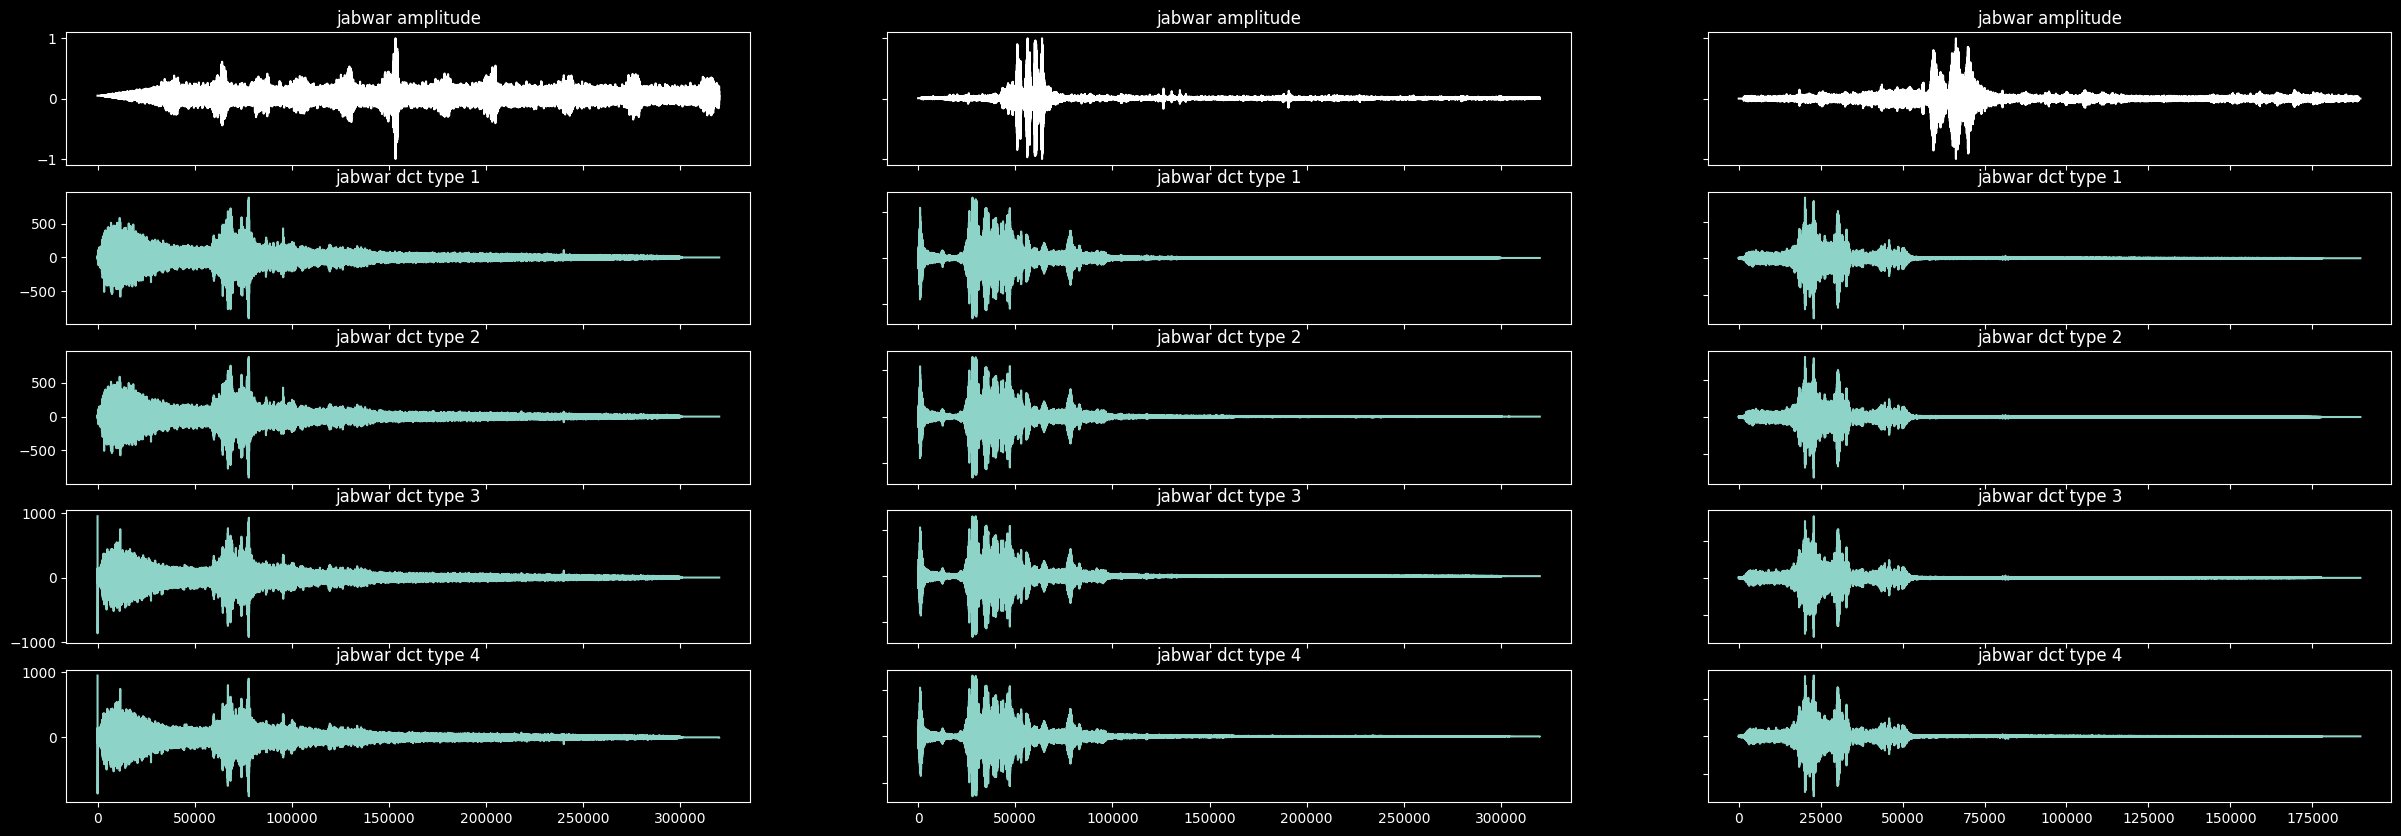

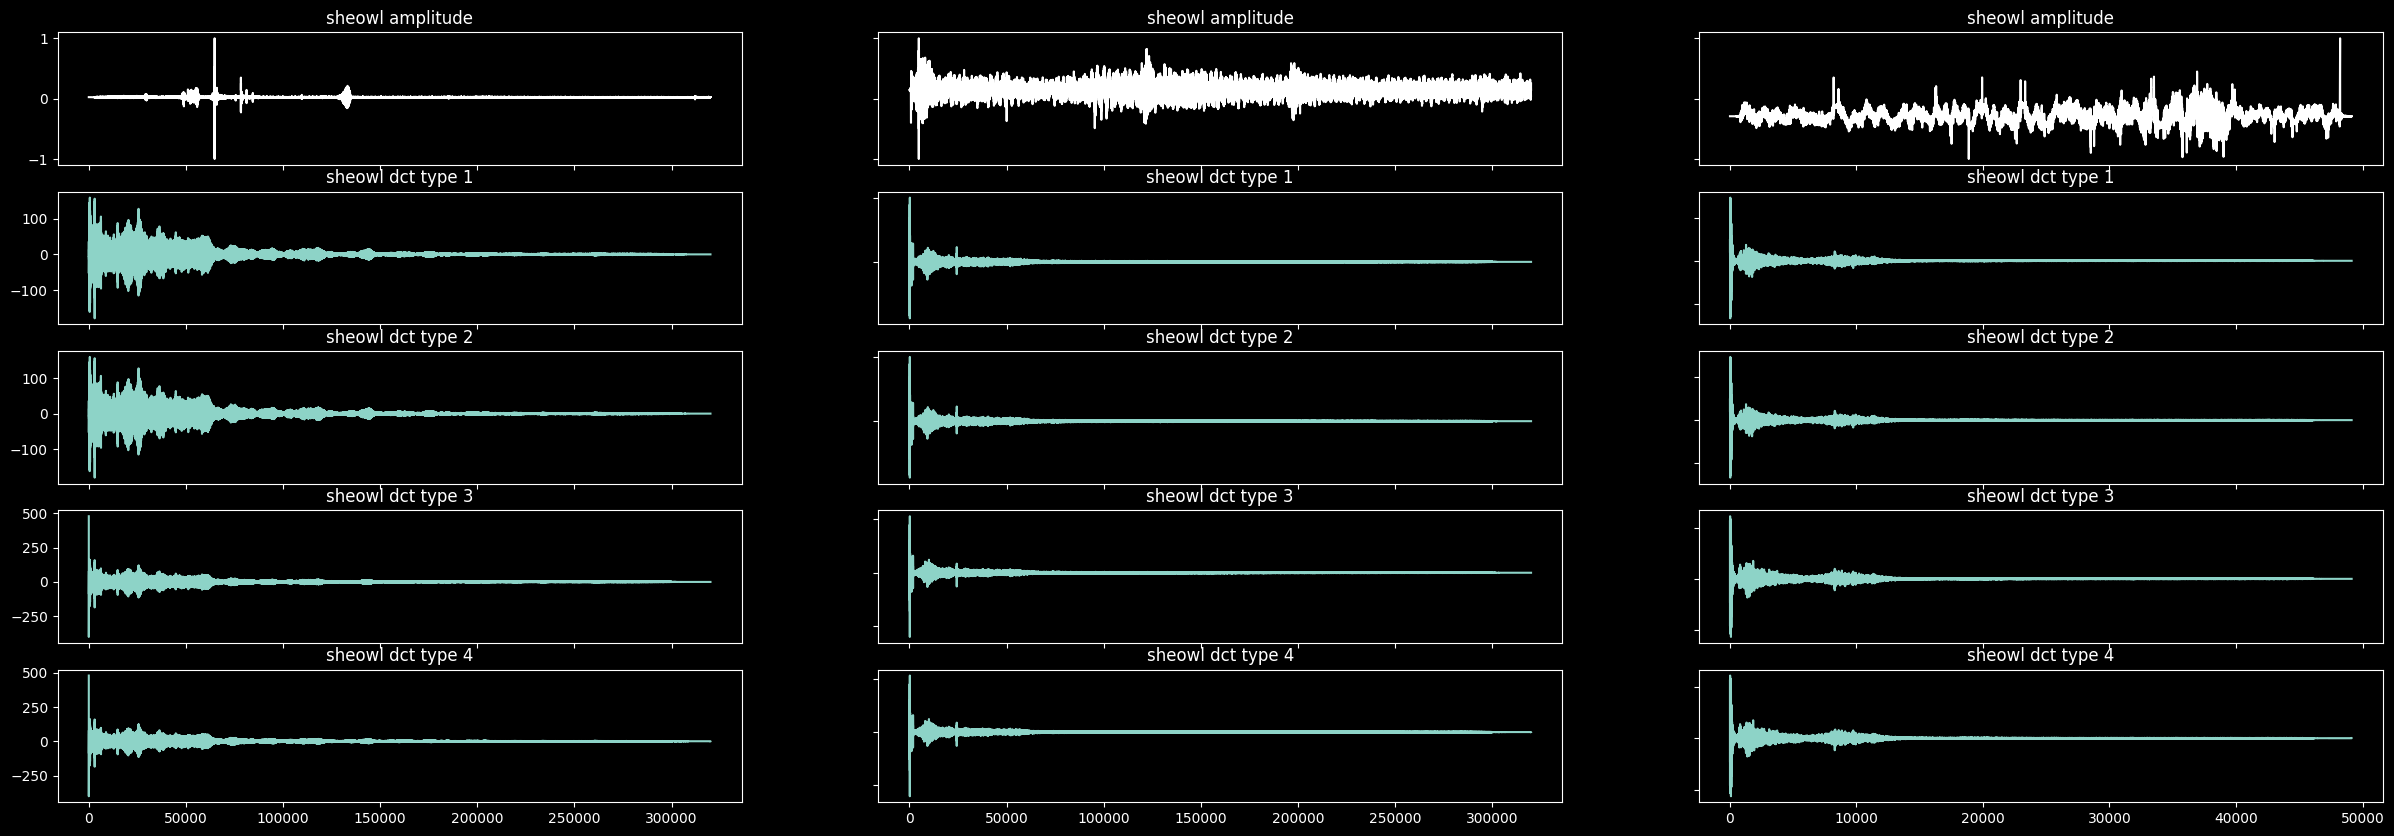

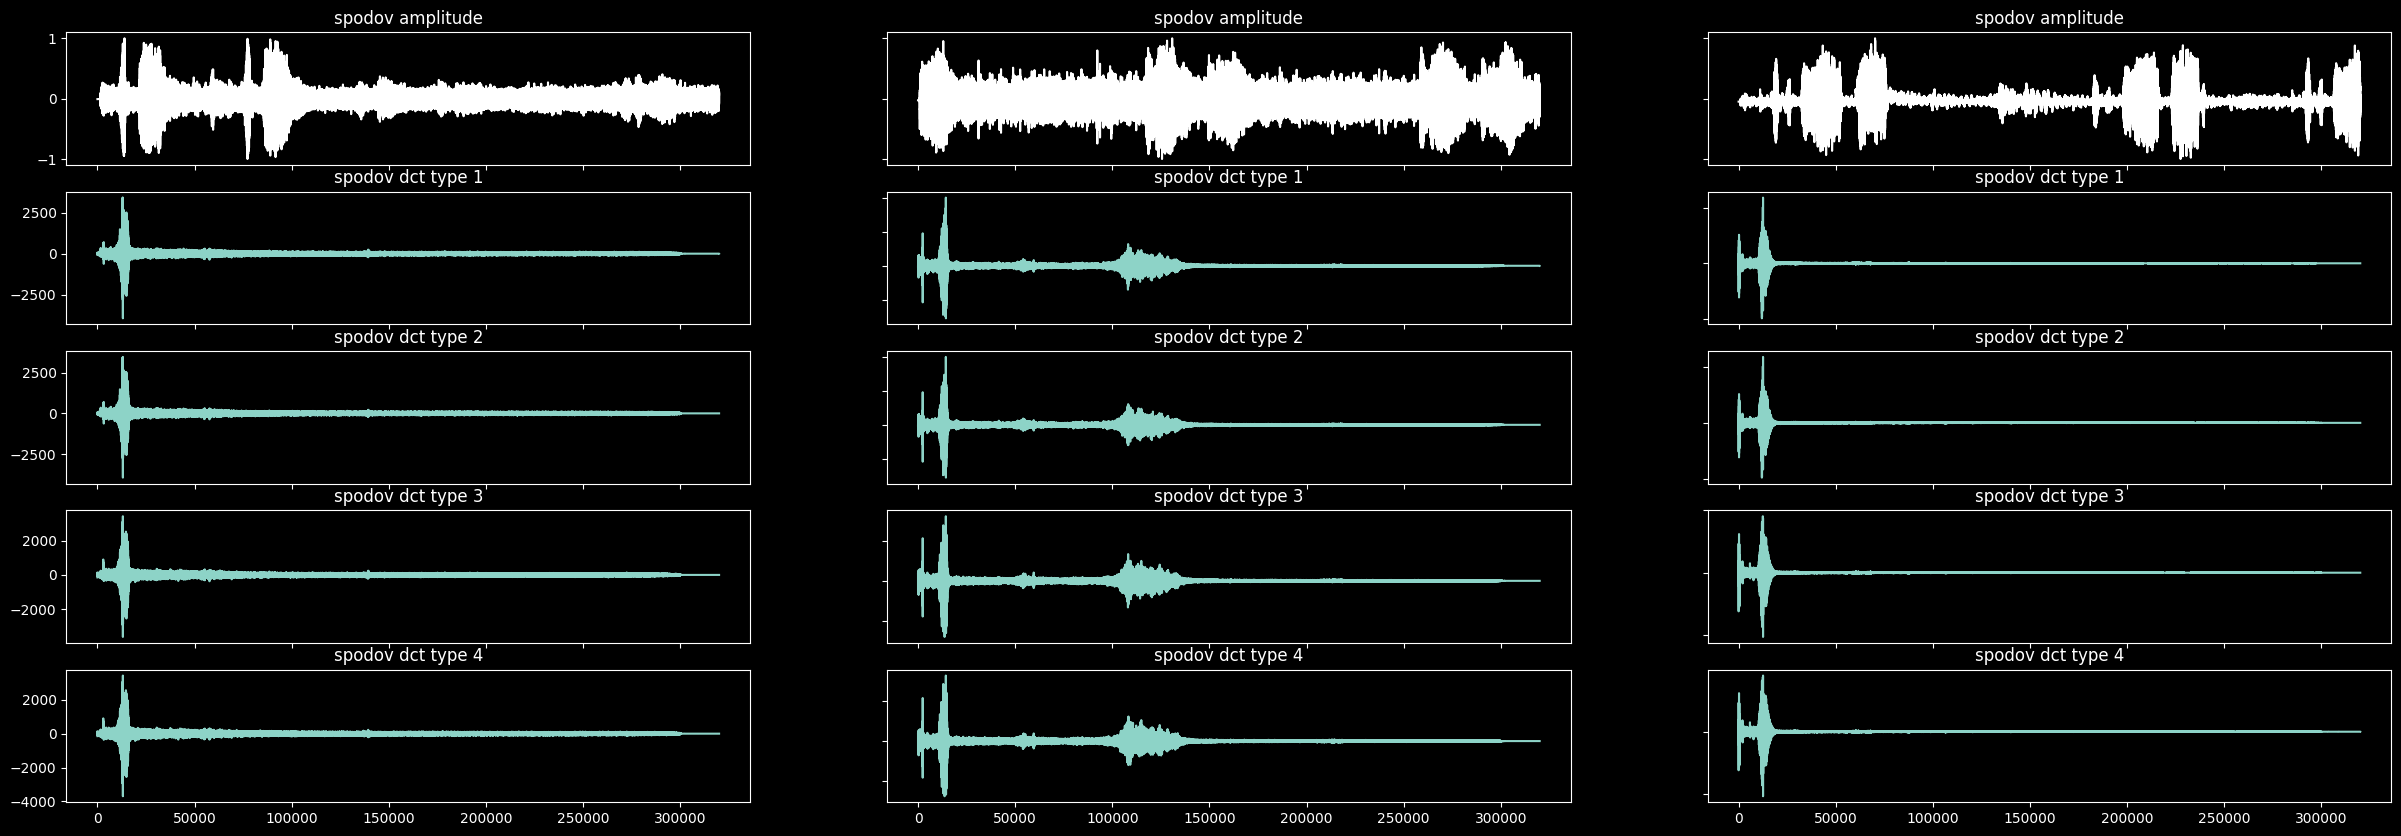

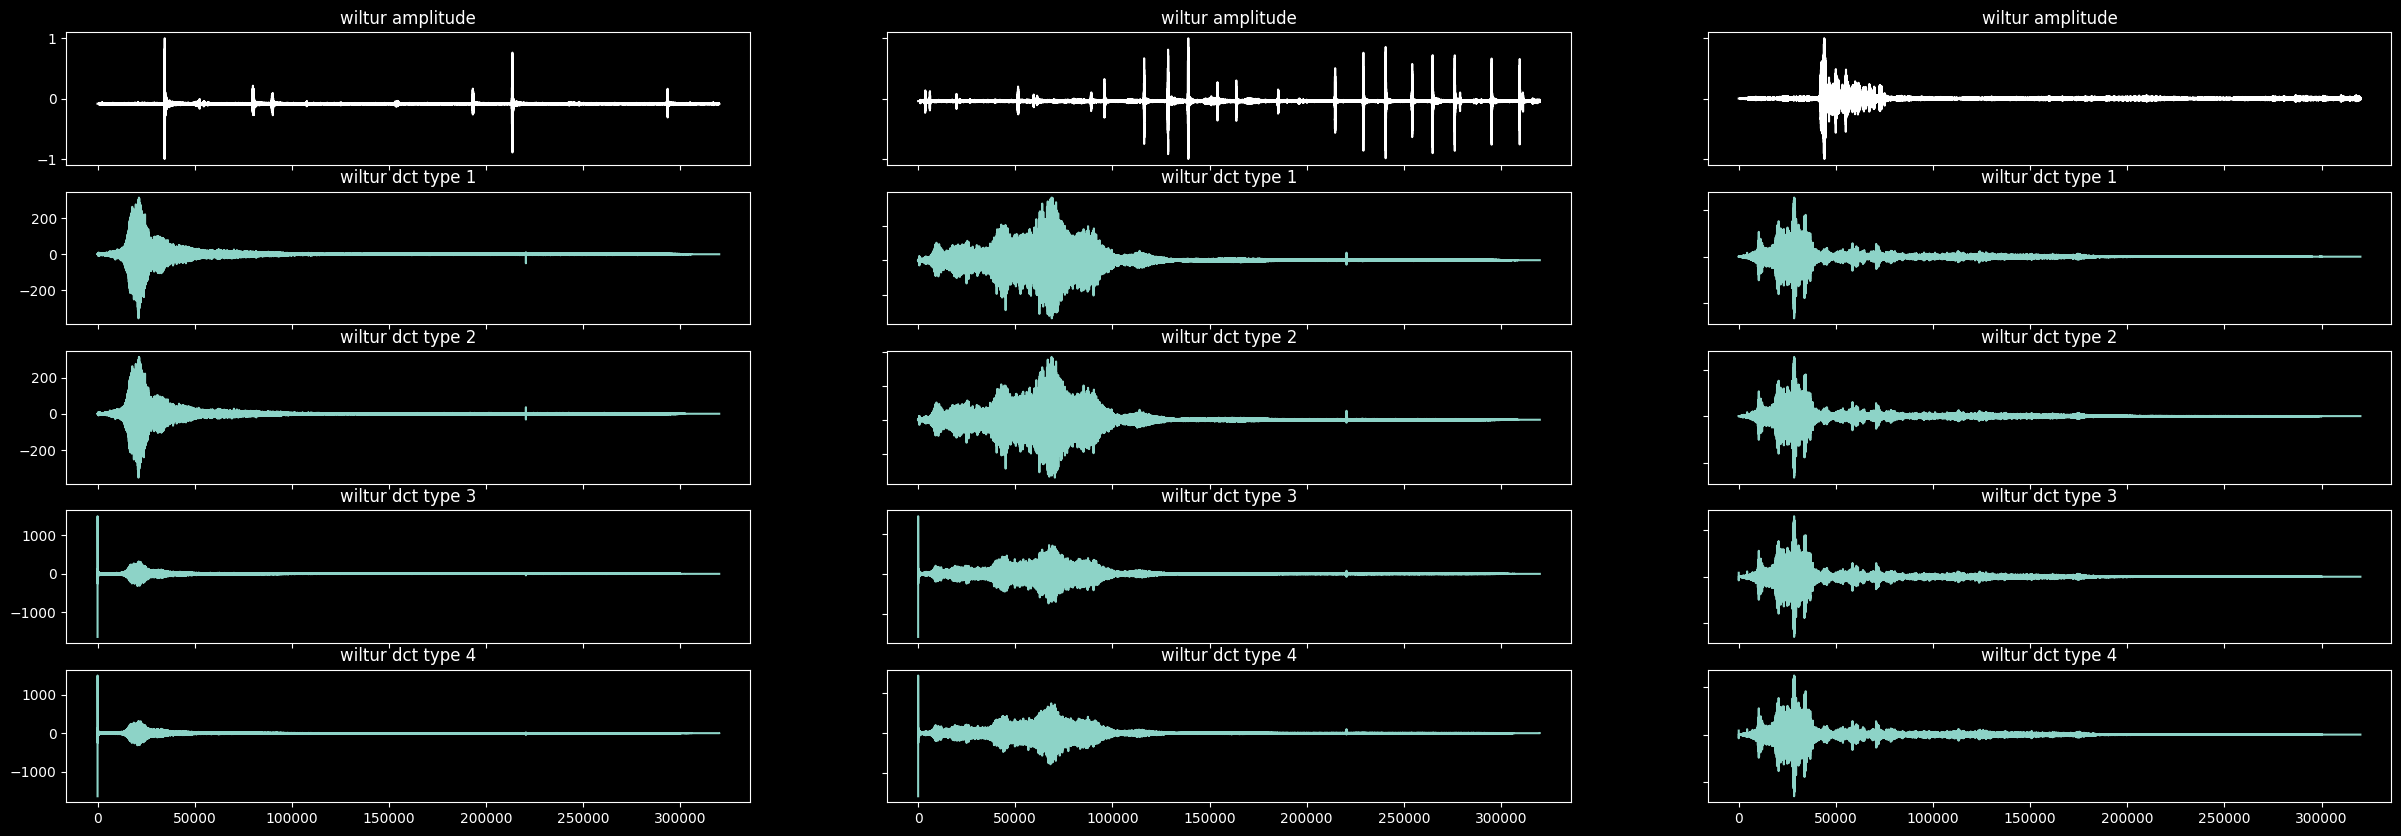

In [13]:
# plot three samples of audio from each target class
N_COLS=3

for target_index, target in enumerate(target_datasets.keys()):
    
    # create a pipeline to load the audio file
    audio_dataset = make_data_pipeline(target_datasets[target])
    
    # 5 rows per audio clip (3 columns one for each clip)
    fig, axs = plt.subplots(nrows=5, ncols=N_COLS, figsize=(30,10))
    
    for audio_index, (audio, rate, label) in enumerate(audio_dataset.take(N_COLS)):    

        # convert to numpy array
        audio_np = audio.numpy()[0:rate*CLIP_LENGTH]  
        axs[0, audio_index].plot(audio_np[10:], color="white")    
        axs[0, audio_index].set_title(label.numpy().decode("utf-8") + " amplitude") 
        
        # plot dct type 1
        result = scipy.fft.dct(audio_np, type=1, n=None, axis=-1, norm=None, overwrite_x=False, workers=None, orthogonalize=False)
        axs[1, audio_index].plot(result[10:])
        axs[1, audio_index].set_title(label.numpy().decode("utf-8") + " dct type 1") 
        
        # plot dct type 2
        result = scipy.fft.dct(audio_np, type=2, n=None, axis=-1, norm=None, overwrite_x=False, workers=None, orthogonalize=False)
        axs[2, audio_index].plot(result[10:])
        axs[2, audio_index].set_title(label.numpy().decode("utf-8") + " dct type 2") 
        
        # plot dct type 3
        result = scipy.fft.dct(audio_np, type=3, n=None, axis=-1, norm=None, overwrite_x=False, workers=None, orthogonalize=False)
        axs[3, audio_index].plot(result[10:])
        axs[3, audio_index].set_title(label.numpy().decode("utf-8") + " dct type 3") 
        
        # plot dct type 4
        result = scipy.fft.dct(audio_np, type=4, n=None, axis=-1, norm=None, overwrite_x=False, workers=None, orthogonalize=False)
        axs[4, audio_index].plot(result[10:])     
        axs[4, audio_index].set_title(label.numpy().decode("utf-8") + " dct type 4")   
        
    for ax in axs.flat:
        ax.label_outer()  

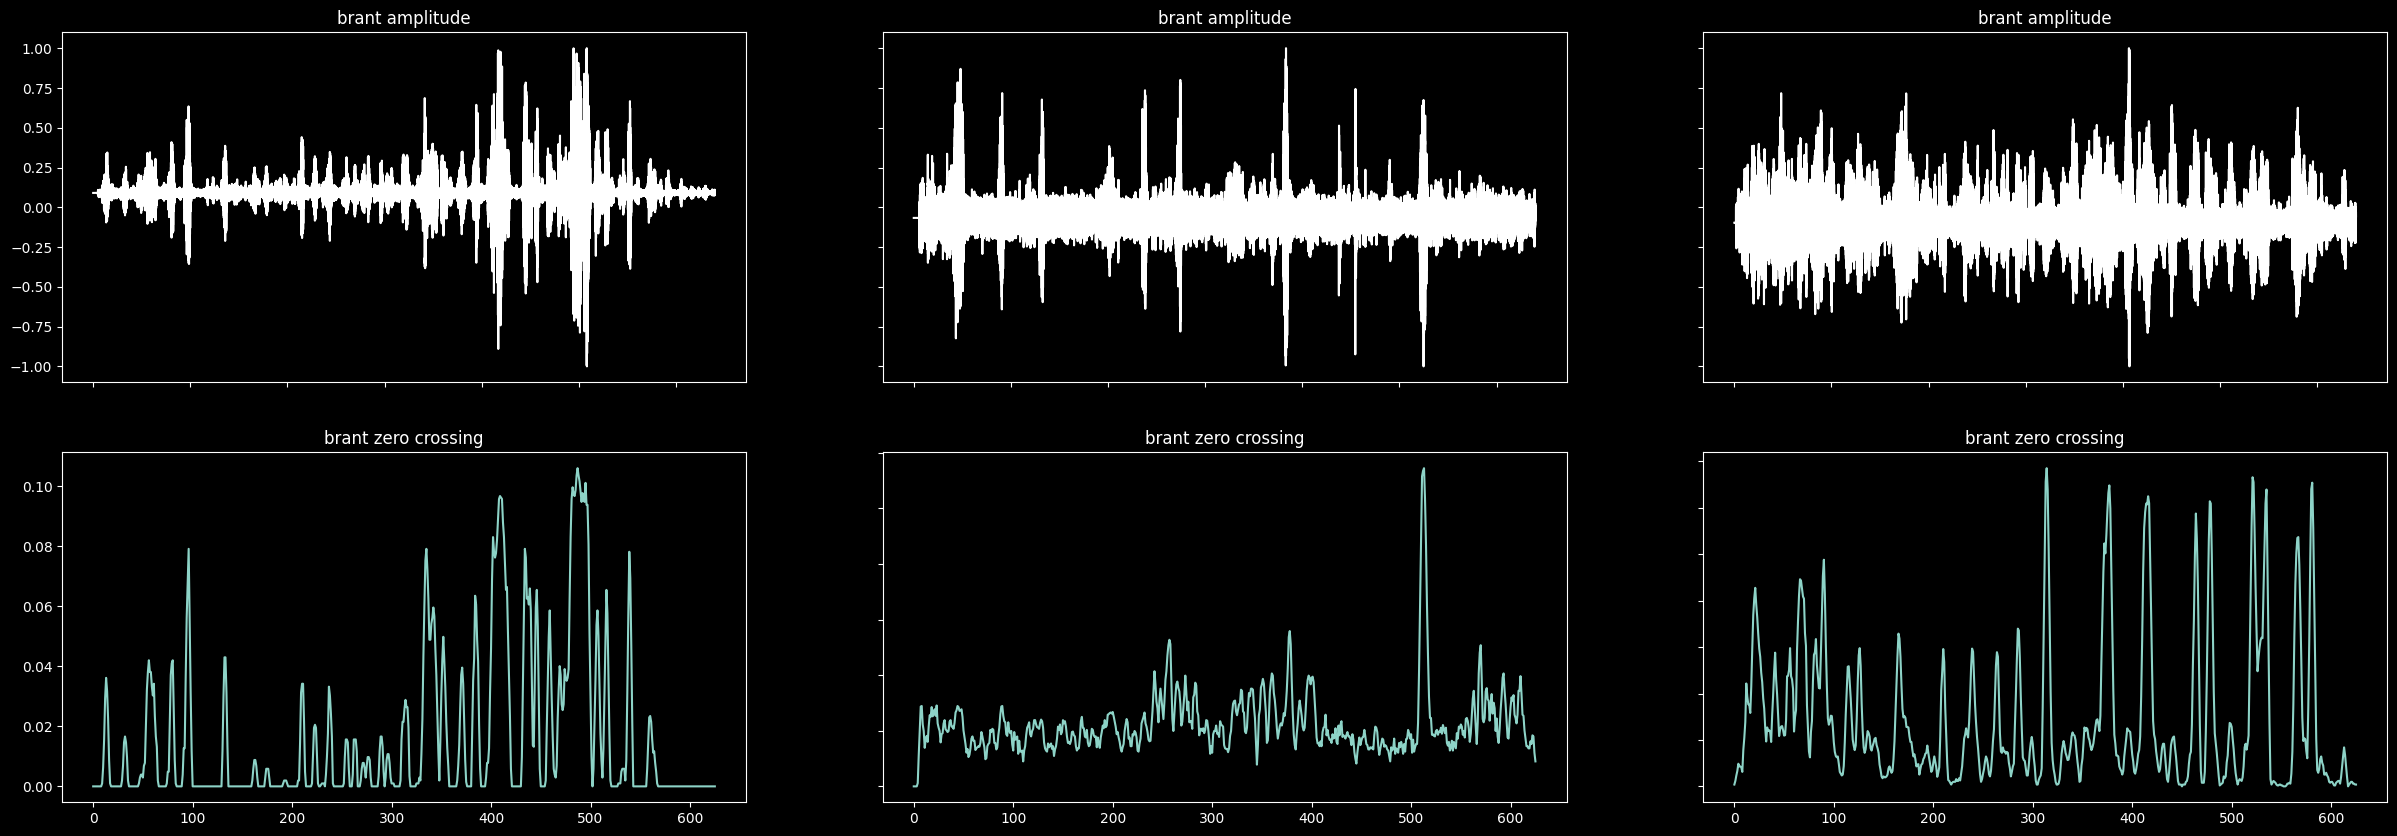

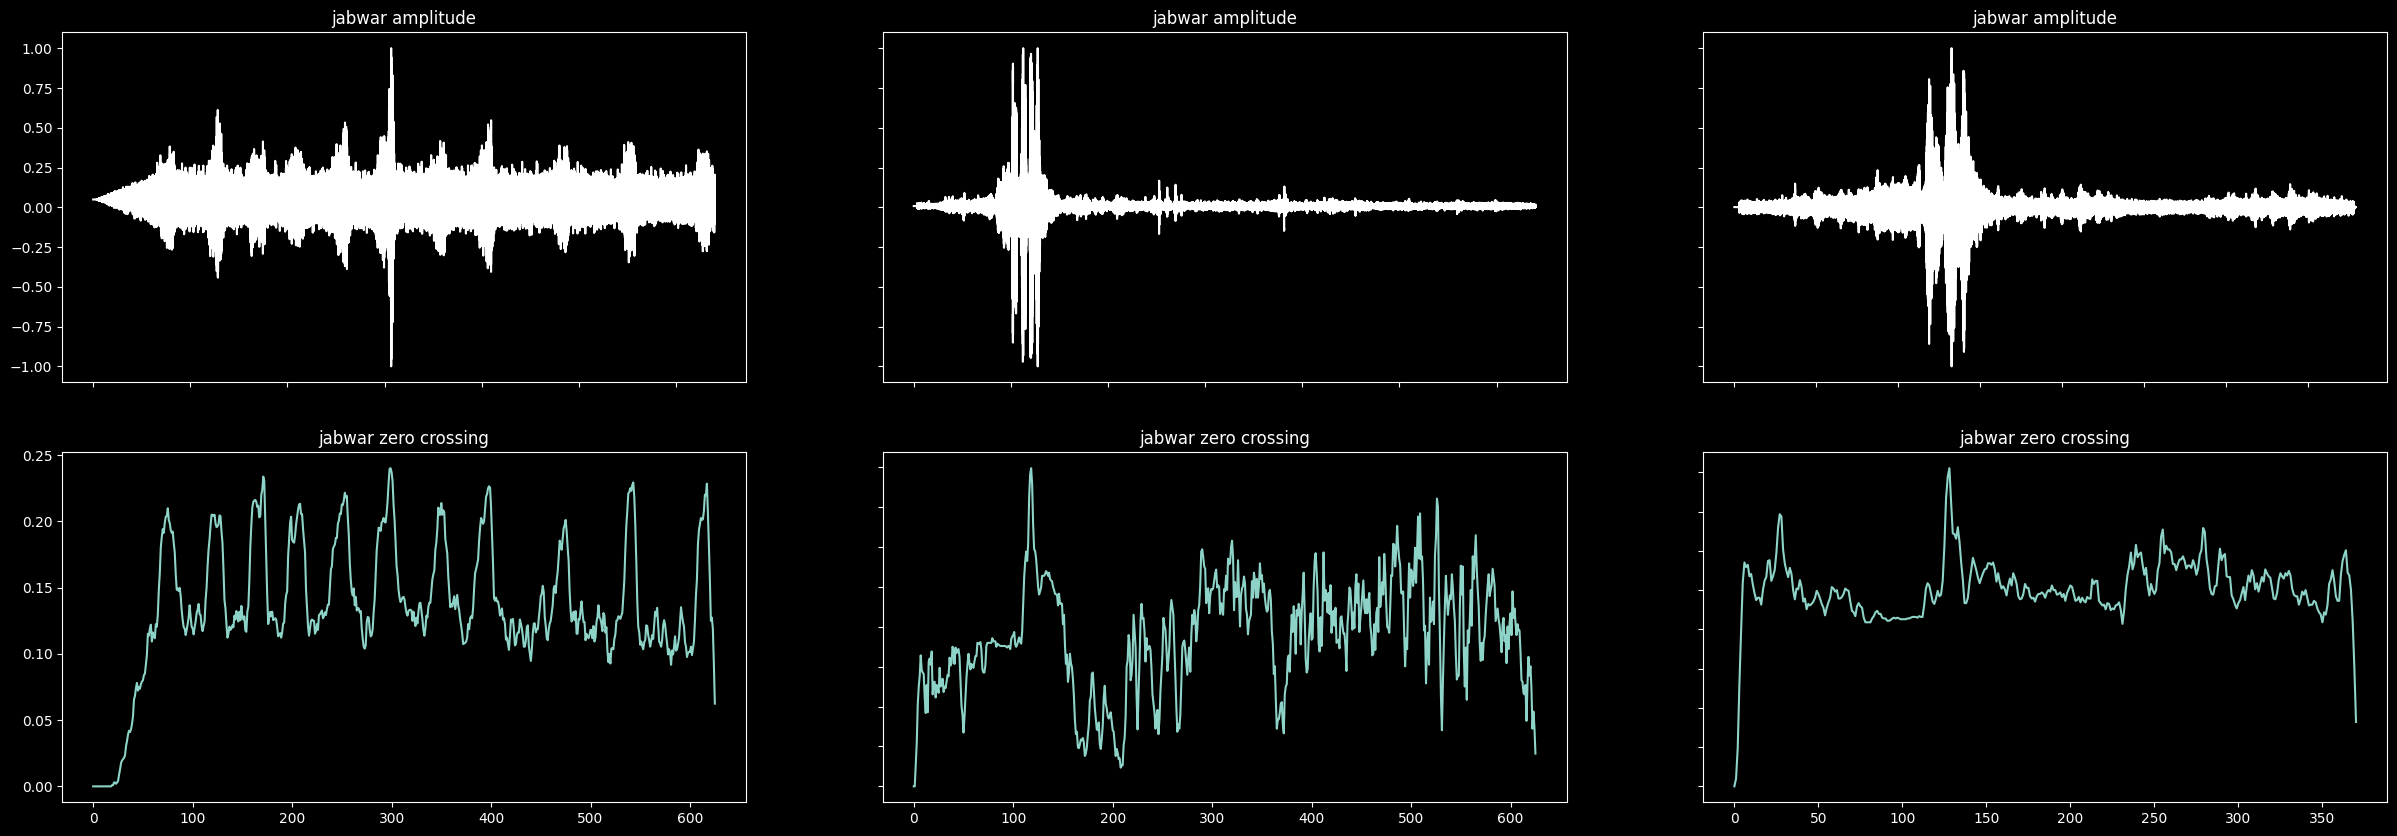

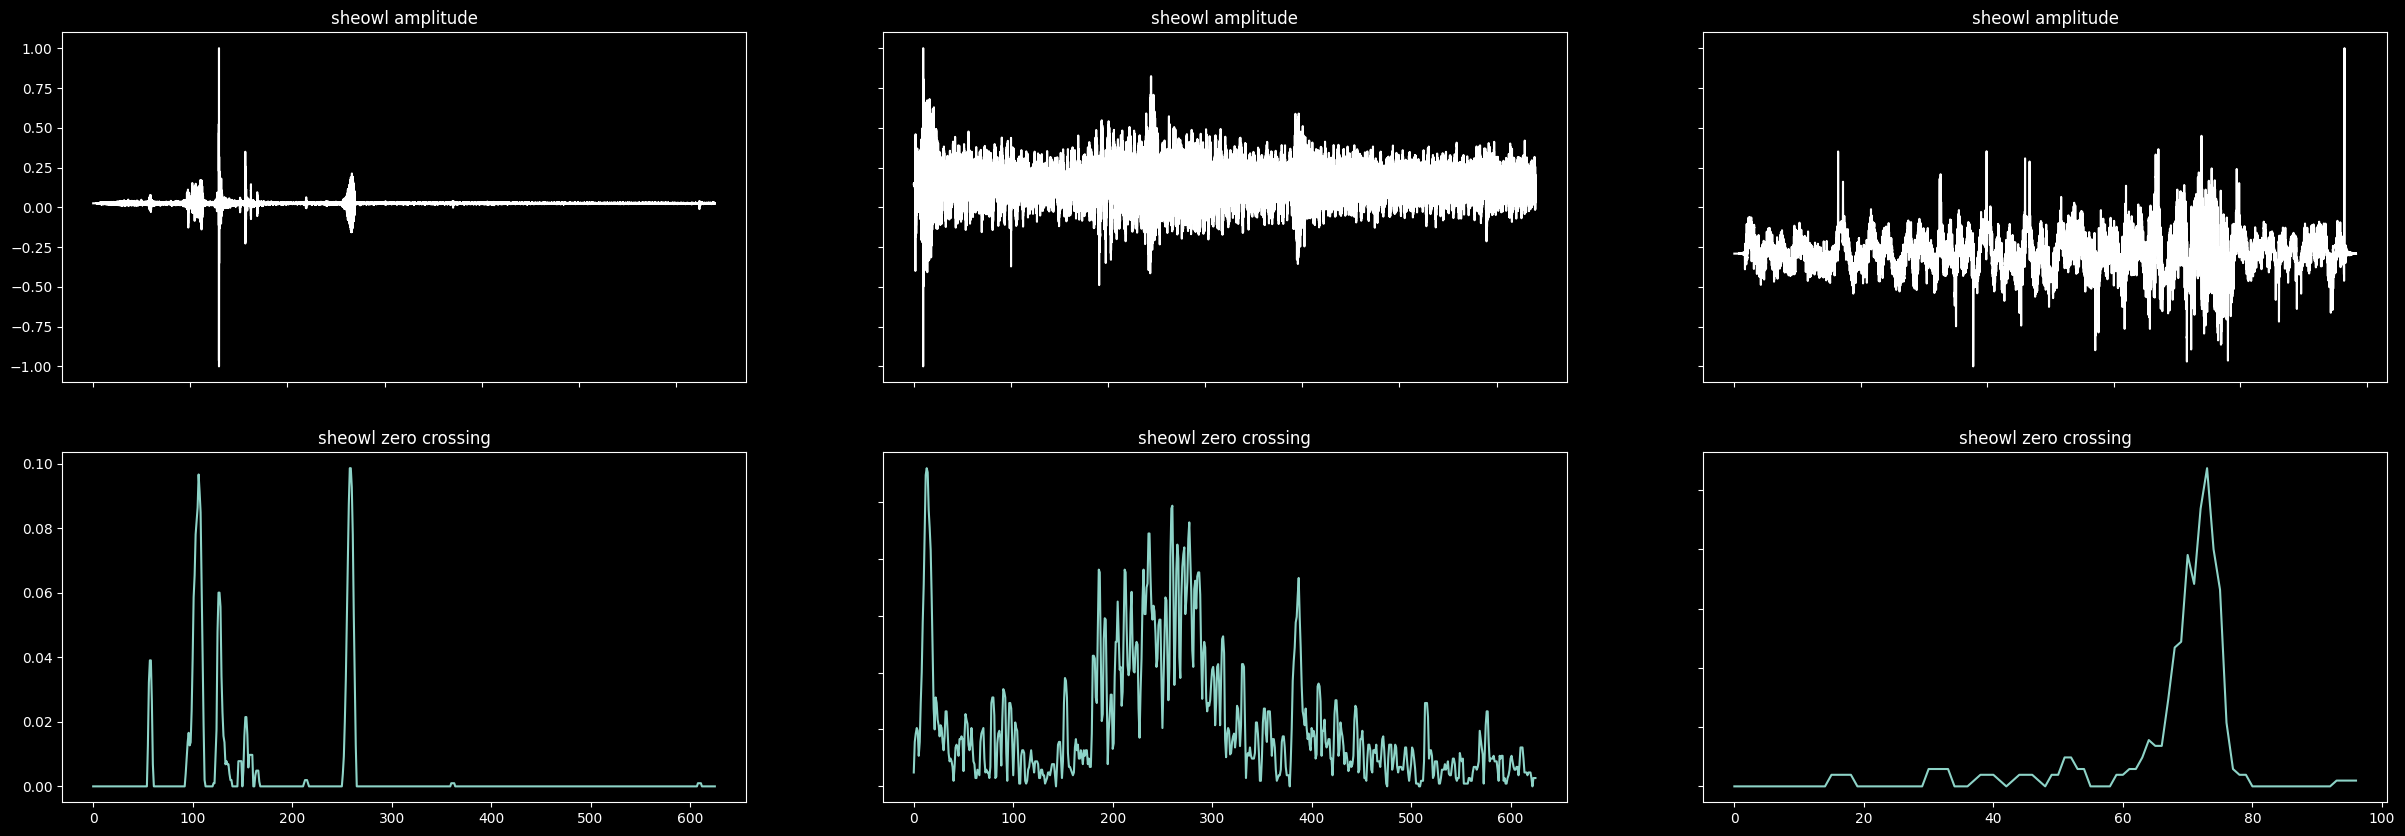

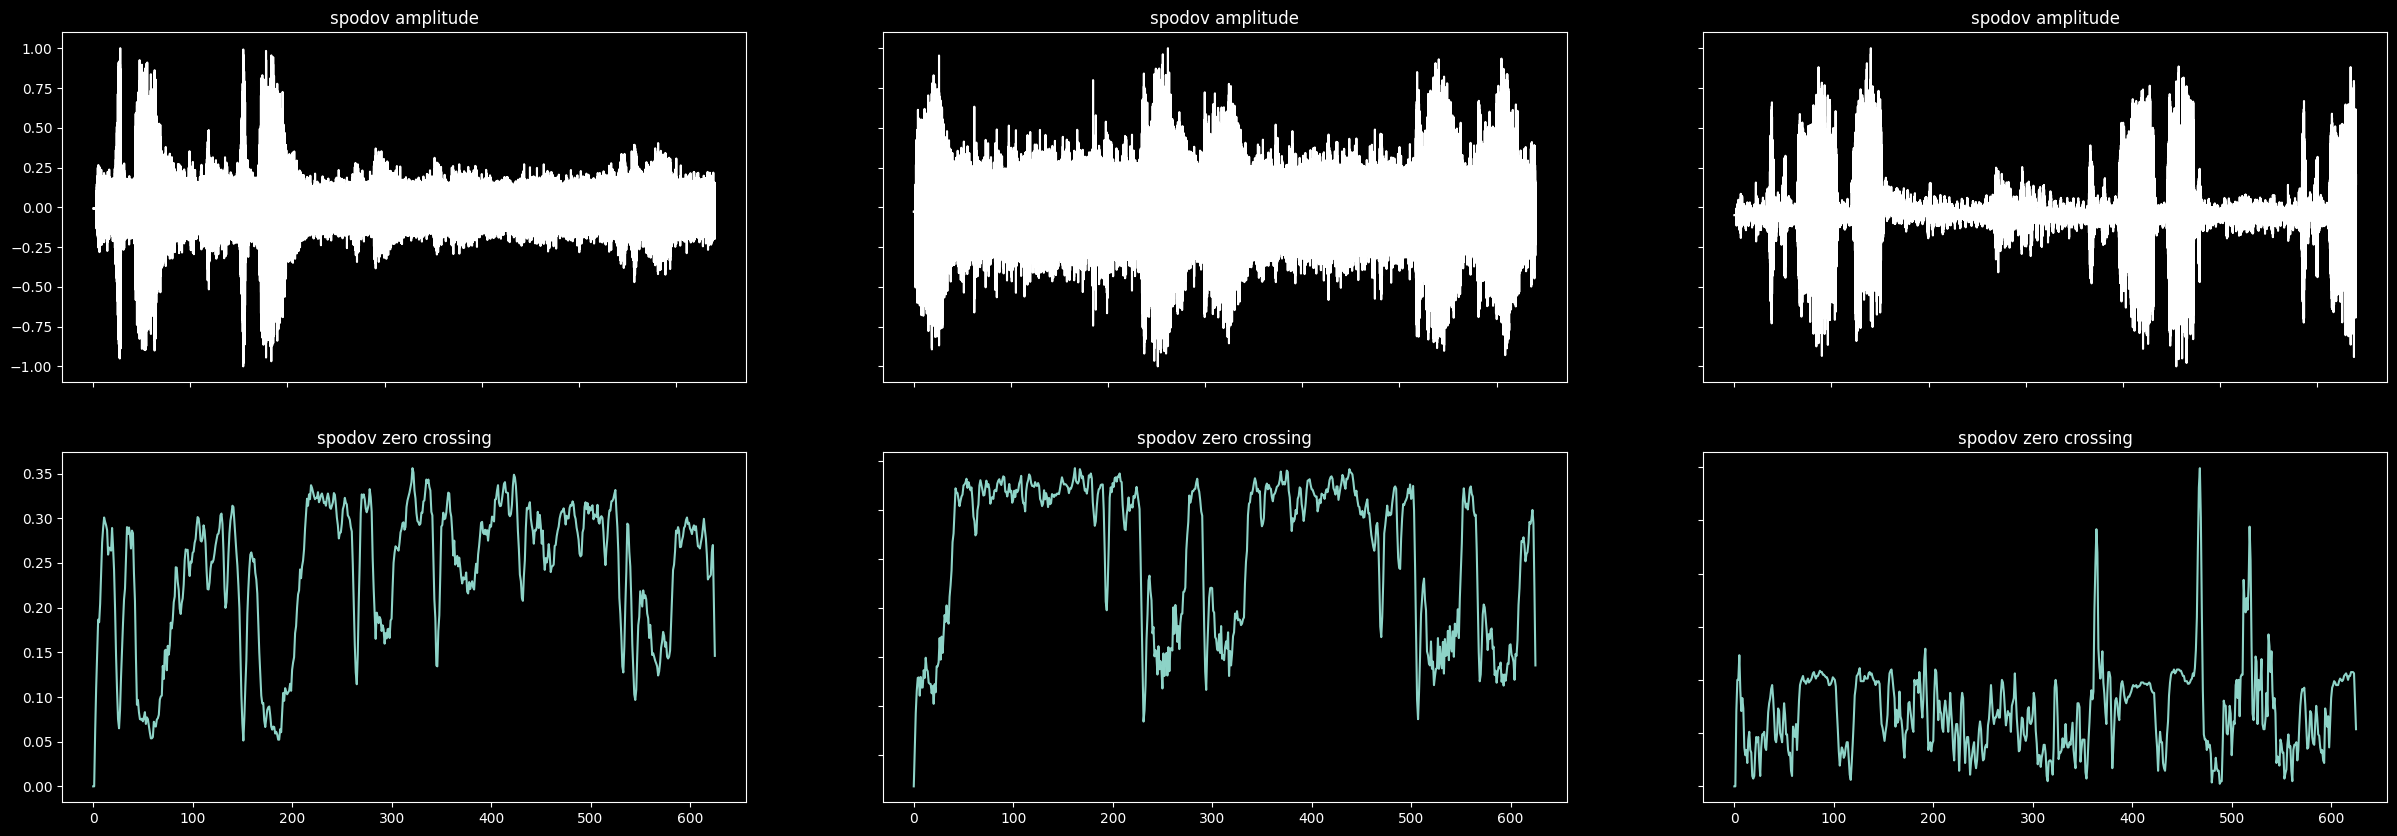

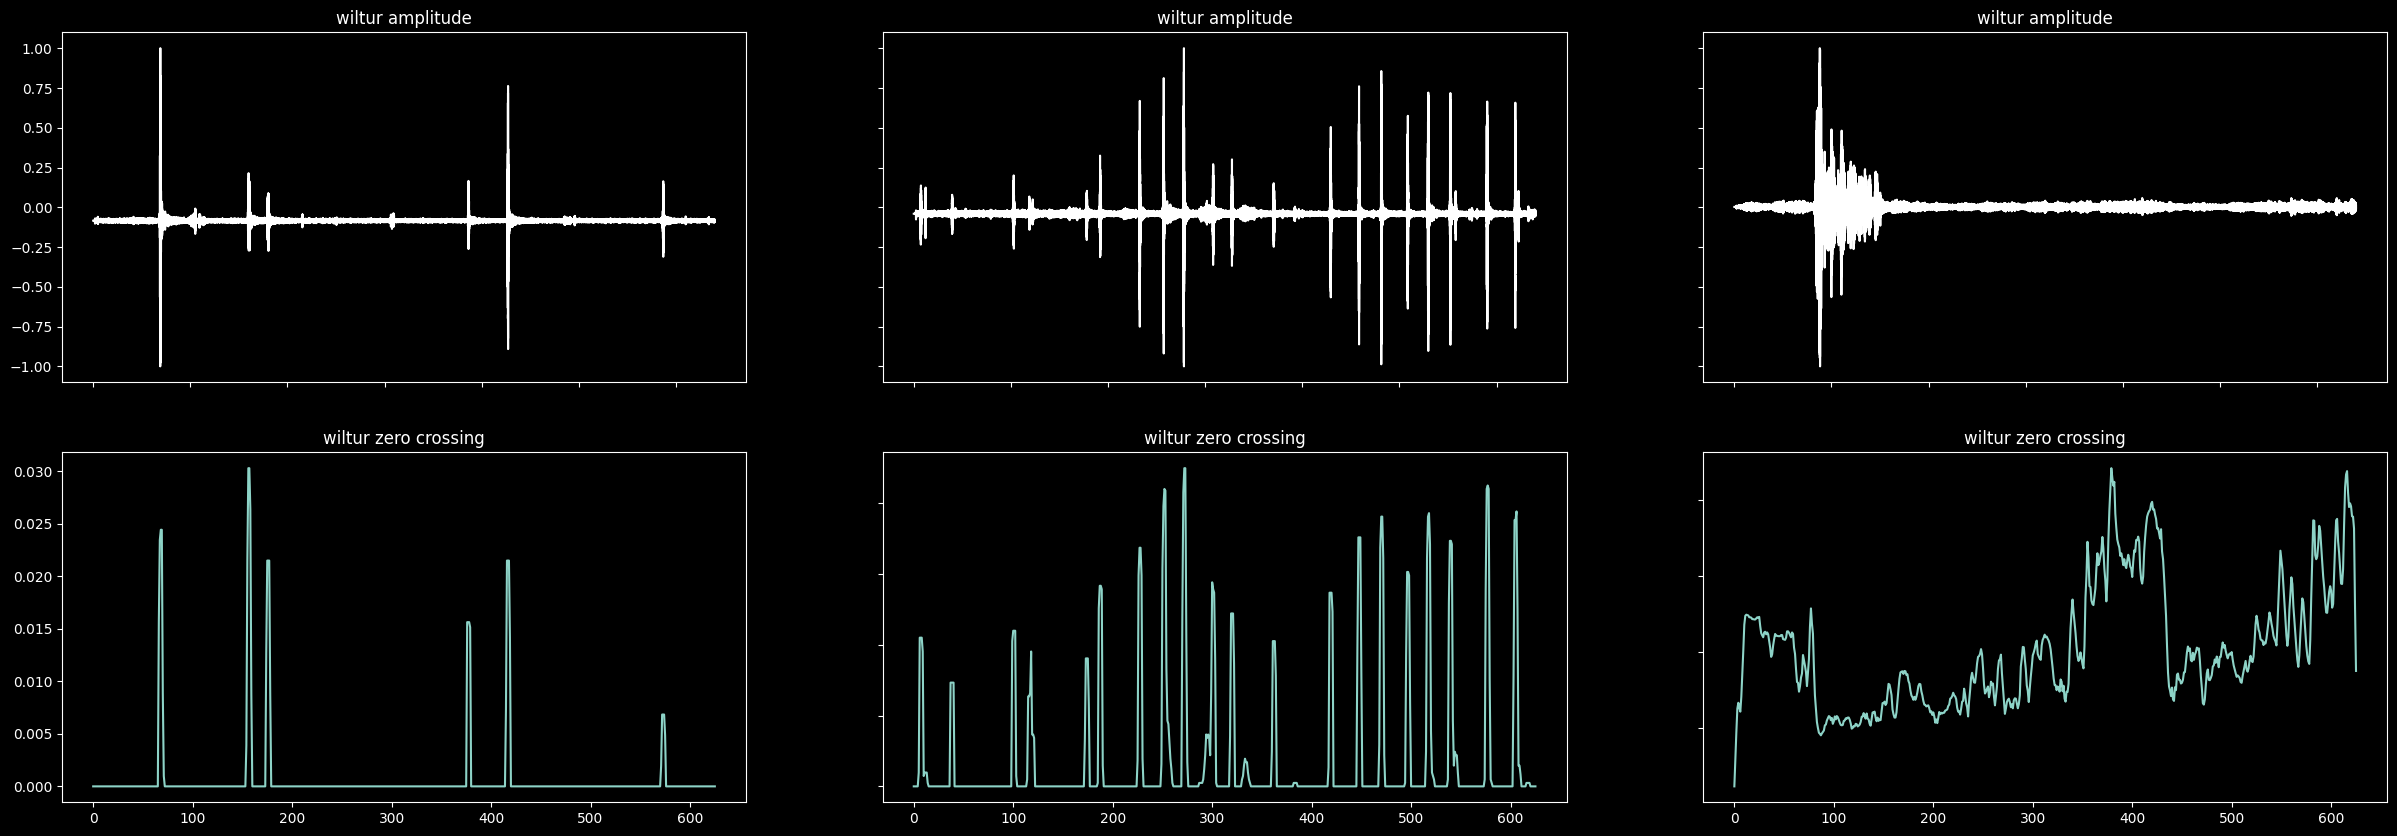

In [14]:
# plot three samples of audio from each target class
N_COLS=3

for target_index, target in enumerate(target_datasets.keys()):
    
    # create a pipeline to load the audio file
    audio_dataset = make_data_pipeline(target_datasets[target])
    
    # 2 rows per audio clip (3 columns one for each clip)
    fig, axs = plt.subplots(nrows=2, ncols=N_COLS, figsize=(30,10))
    
    for audio_index, (audio, rate, label) in enumerate(audio_dataset.take(N_COLS)):    

        # convert to numpy array
        audio_np = audio.numpy()[0:rate*CLIP_LENGTH]  
        axs[0, audio_index].plot(audio_np, color="white")    
        axs[0, audio_index].set_title(label.numpy().decode("utf-8") + " amplitude") 
        
        # zero crossing rate
        result = librosa.feature.zero_crossing_rate(audio_np) 
        # print(result.shape, result)
        axs[1, audio_index].plot(result.squeeze())
        axs[1, audio_index].set_title(label.numpy().decode("utf-8") + " zero crossing") 
                
    for ax in axs.flat:
        ax.label_outer()